In [607]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict
#from sklearn.grid_search import GridSearchCV

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.svm import SVC, LinearSVC

from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import SGDClassifier

from sklearn import naive_bayes
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


In [608]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [609]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [610]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [611]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Performing Data Cleaning and Analysis
<!-- #### 1. Understanding meaning of each column: -->
<!-- <br>Data Dictionary: -->
<br>**Variable        Description**</br>
1. Survived	- Survived (1) or died (0)
2. Pclass -	Passenger’s class (1 = 1st, 2 = 2nd, 3 = 3rd)
3. Name	- Passenger’s name
4. Sex -	Passenger’s sex
5. Age	- Passenger’s age
6. SibSp -	Number of siblings/spouses aboard
7. Parch -	Number of parents/children aboard (Some children travelled only with a nanny, therefore parch=0 for them.)
8. Ticket -	Ticket number
9. Fare -	Fare
10. Cabin -	Cabin
11. Embarked -	Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)


In [612]:
"""
Deleting the columns not required for determining the survival of a person
"""

del train['PassengerId']
del train['Ticket']
del train['Fare']
del train['Cabin']
del train['Name']


In [613]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


In [614]:
train.shape

(891, 7)

In [615]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch
count,891.000000,891.000000,714.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594
std,0.486592,0.836071,14.526497,1.102743,0.806057
min,0.000000,1.000000,0.420000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000
75%,1.000000,3.000000,38.000000,1.000000,0.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000


In [616]:
train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Embarked      2
dtype: int64

In [617]:
"""
Deleting the columns not required for determining the survival of a person for the data stored in test.csv
"""

del test['Ticket']
del test['Fare']
del test['Cabin']
del test['Name']


test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked
0,892,3,male,34.5,0,0,Q
1,893,3,female,47.0,1,0,S
2,894,2,male,62.0,0,0,Q
3,895,3,male,27.0,0,0,S
4,896,3,female,22.0,1,1,S


In [618]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch
count,418.000000,418.000000,332.000000,418.000000,418.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344
std,120.810458,0.841838,14.181209,0.896760,0.981429
min,892.000000,1.000000,0.170000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000
50%,1100.500000,3.000000,27.000000,0.000000,0.000000
75%,1204.750000,3.000000,39.000000,1.000000,0.000000
max,1309.000000,3.000000,76.000000,8.000000,9.000000


In [619]:
test.isnull().sum()

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Embarked        0
dtype: int64

In [620]:
#We will create a new column called "Gender" and
#fill it with values 1 ,2 based on the values of sex column in which male = 1 and female = 2

def getNum(str):
    if str == 'male':
        return '1'
    if str == 'female':
        return '2'

train['Gender'] = train['Sex'].apply(getNum)
print(train.head())

print("#"*50)

test['Gender'] = test['Sex'].apply(getNum)

# Delete the Sex columns
del train['Sex']
del test['Sex']

#Renaming "gender" column
train.rename(columns={'Gender':'Sex'}, inplace=True)

test.rename(columns={'Gender':'Sex'}, inplace=True)
test.head()

   Survived  Pclass     Sex   Age  SibSp  Parch Embarked Gender
0         0       3    male  22.0      1      0        S      1
1         1       1  female  38.0      1      0        C      2
2         1       3  female  26.0      0      0        S      2
3         1       1  female  35.0      1      0        S      2
4         0       3    male  35.0      0      0        S      1
##################################################


,PassengerId,Pclass,Age,SibSp,Parch,Embarked,Sex
0,892,3,34.5,0,0,Q,1
1,893,3,47.0,1,0,S,2
2,894,2,62.0,0,0,Q,1
3,895,3,27.0,0,0,S,1
4,896,3,22.0,1,1,S,2


## Analyzing Data by Visualization

Inorder to understand who would have had a better probability of survival, we should visualize the patients who survived based on age, passenger class and etc.


<AxesSubplot:xlabel='Survived', ylabel='count'>

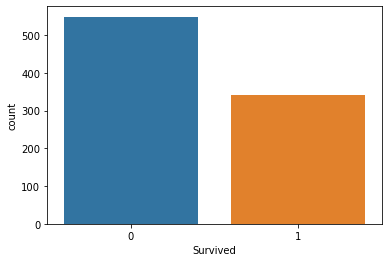

In [621]:
sns.countplot(train['Survived'])

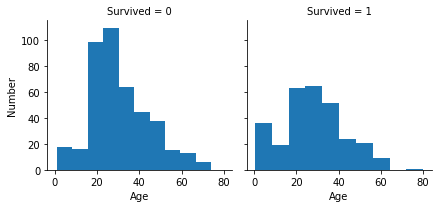

In [622]:
age_hist = sns.FacetGrid(train, col='Survived')
age_hist.map(plt.hist, 'Age')
age_hist.set_ylabels('Number')

## Number of people who survived using the age and passenger class


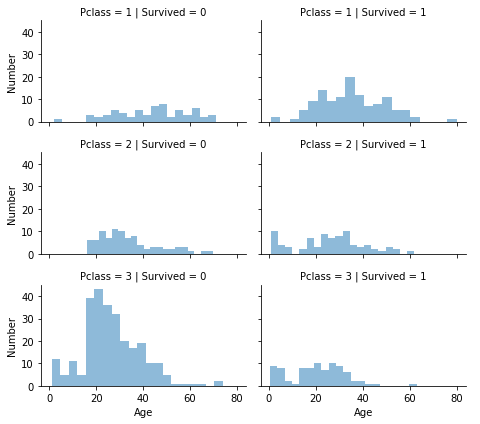

In [623]:
pclass_age_grid = sns.FacetGrid(train, col='Survived', row='Pclass', height=2.0, aspect=1.6)
pclass_age_grid.map(plt.hist, 'Age', alpha=0.5, bins=20)
pclass_age_grid.add_legend()
pclass_age_grid.set_ylabels('Number')

## Handling the NULL values in the column Age

#### We have NULL value inplace of Age for some of the people in both training and testing data.
#### So, one way is to fill them with the mean values i.e. fill the ones who have survived with the mean age of the survived people and similarly fill those who haven't survived with the mean age of all non-survived people.

#### But, this will only solve the problem for the training data and not for the testing data as we have to predict their survival status.

#### So, we can tackle the issue by creating an array that contains random numbers, which are computed based on the mean age value in regard to the standard deviation and is_null.



In [624]:
# finding average survived age
age_sur_mean = train[train.Survived==1]['Age'].mean()

age_sur_mean


28.343689655172415

### The avarage age of survived is 28.

In [625]:
# Finding the mean age of "Not Survived" people
age_nsur_mean = train[train.Survived==0]['Age'].mean()

age_nsur_mean

30.62617924528302

In [626]:
# Solving the null values in Age column

data = [train, test]
for data_point in data:
    mean = train['Age'].mean()
    std = test["Age"].std()
    is_null = data_point['Age'].isnull().sum()

    # compute the random range of age where mean-std, mean+std and is_null -> (start, high, size)
    random_age = np.random.randint(mean - std, mean + std, size=is_null)

    # Fill the random_age into NaN in Age columns
    age_copy = data_point['Age'].copy()
    age_copy[np.isnan(age_copy)] = random_age
    data_point['Age'] = age_copy
    data_point['Age'] = train['Age'].astype(int)

train['Age'].isnull().sum()

0

In [627]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Embarked,Sex
0,0,3,22,1,0,S,1
1,1,1,38,1,0,C,2
2,1,3,26,0,0,S,2
3,1,1,35,1,0,S,2
4,0,3,35,0,0,S,1


In [628]:
"""Since there are ONLY 2 rows whose Embarked data is not known,
therefore we can neglect those 2 rows by dropping them as they will not make much of a difference"""

# Removing the 2 rows having null value for Embarked column
train.dropna(inplace=True)

In [629]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Survived  889 non-null    int64 
 1   Pclass    889 non-null    int64 
 2   Age       889 non-null    int32 
 3   SibSp     889 non-null    int64 
 4   Parch     889 non-null    int64 
 5   Embarked  889 non-null    object
 6   Sex       889 non-null    object
dtypes: int32(1), int64(4), object(2)
memory usage: 52.1+ KB


### Grouping the Age data

#### The age groups need to be converted into different sub-groups so that better prediction model can be formed


In [630]:
print(train['Age'].min())
print(train['Age'].max())
print(train['Age'].unique())

0
80
[22 38 26 35 31 54  2 27 14  4 58 20 39 55 33 24 34 15 28  8 21 19 40 23
 66 42 18  3  7 49 29 65  5 11 45 17 32 16 25  0 30 46 59 71 37 47 70 12
  9 36 51 44  1 61 56 50 62 41 52 63 43 60 10 64 13 48 53 57 80  6 74]


In [631]:
data=[train,test]

for data_point in data:
    data_point.loc[ data_point['Age'] <= 10, 'Age'] = 0
    data_point.loc[(data_point['Age'] > 10) & (data_point['Age'] <= 20), 'Age'] = 1
    data_point.loc[(data_point['Age'] > 20) & (data_point['Age'] <= 30), 'Age'] = 2
    data_point.loc[(data_point['Age'] > 30) & (data_point['Age'] <= 40), 'Age'] = 3
    data_point.loc[(data_point['Age'] > 40) & (data_point['Age'] <= 50), 'Age'] = 4
    data_point.loc[(data_point['Age'] > 50) & (data_point['Age'] <= 60), 'Age'] = 5
    data_point.loc[(data_point['Age'] > 60) & (data_point['Age'] <= 70), 'Age'] = 6
    data_point.loc[ data_point['Age'] > 70 , 'Age'] = 7

train['Age'].value_counts()


2    299
3    220
1    152
4     91
0     64
5     42
6     17
7      4
Name: Age, dtype: int64

In [632]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Embarked,Sex
0,0,3,2,1,0,S,1
1,1,1,3,1,0,C,2
2,1,3,2,0,0,S,2
3,1,1,3,1,0,S,2
4,0,3,3,0,0,S,1


In [633]:
data = [train, test]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map({'C': 0, 'S': 1, 'Q': 2}).astype(int)

## Probability of Survived to other features

Like Pclass, Gender, SibSp, Parch etc.


In [634]:
train[['Embarked', "Survived"]].groupby(['Embarked']).mean().sort_values(by='Survived', ascending=True)

,Survived
Embarked,
1,0.336957
2,0.389610
0,0.553571


In [635]:
train[['Age', 'Survived']].groupby(['Age']).mean().sort_values(by='Survived', ascending=True)

,Survived
Age,
6,0.176471
7,0.250000
2,0.347826
1,0.361842
4,0.362637
3,0.404545
5,0.404762
0,0.593750


In [636]:
train[['Pclass', 'Survived']].groupby(['Pclass']).mean().sort_values(by='Survived', ascending=True)

,Survived
Pclass,
3,0.242363
2,0.472826
1,0.626168


In [637]:

train[['Sex', 'Survived']].groupby(['Sex']).mean().sort_values(by='Survived', ascending=True)

,Survived
Sex,
1,0.188908
2,0.740385


In [638]:
train[['Parch', 'Survived']].groupby(['Parch']).mean().sort_values(by='Survived', ascending=True)

,Survived
Parch,
4,0.000000
6,0.000000
5,0.200000
0,0.341716
2,0.500000
1,0.550847
3,0.600000


In [639]:
train[['SibSp', 'Survived']].groupby(['SibSp']).mean().sort_values(by='Survived', ascending=True)

,Survived
SibSp,
5,0.000000
8,0.000000
4,0.166667
3,0.250000
0,0.343234
2,0.464286
1,0.535885


In [640]:
"""
Observation is that 'Parent/children' and 'Sibling/Spouse' can be combine to make 'Relative' in which column family_members will be created.
"""

# Combine the columns 'Parch' and 'SibSp' as 'Family_Member'

train['Family_Member'] = train['Parch'] + train['SibSp'] + 1
test['Family_Member'] = test['Parch'] + test['SibSp'] + 1

del train['Parch']
del train['SibSp']
del test['Parch']
del test['SibSp']


<AxesSubplot:>

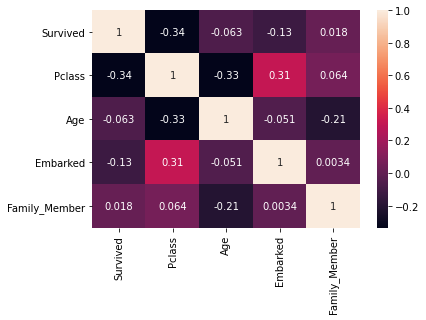

In [641]:
sns.heatmap(train.corr(), annot=True)


<AxesSubplot:>

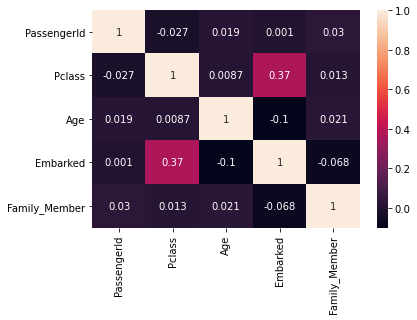

In [642]:
sns.heatmap(test.corr(), annot=True)

## Observation:

The correlation matrix revealed that the features in our dataset are not correlated which mean they are fit for the task.

In [643]:
train

,Survived,Pclass,Age,Embarked,Sex,Family_Member
0,0,3,2,1,1,2
1,1,1,3,0,2,2
2,1,3,2,1,2,1
3,1,1,3,1,2,2
4,0,3,3,1,1,1
...,...,...,...,...,...,...
886,0,2,2,1,1,1
887,1,1,1,1,2,1
888,0,3,4,1,2,4
889,1,1,2,0,1,1


In [644]:
test

,PassengerId,Pclass,Age,Embarked,Sex,Family_Member
0,892,3,2,2,1,1
1,893,3,3,1,2,2
2,894,2,2,2,1,1
3,895,3,3,1,1,1
4,896,3,3,1,2,3
...,...,...,...,...,...,...
413,1305,3,4,1,1,1
414,1306,1,4,0,2,1
415,1307,3,3,1,1,1
416,1308,3,3,1,1,1


## Building Models for Prediction

#### Now we will train multiple Machine Learning algorithms over the training data to predict the survival on our testing data and analyze the results thus obtained.

#### We might also use use cross-validation in the end.

####  We know that since the survival is represented as either 0 or 1, therefore it is a Classification problem. The algorithms used for the same are:
##### Logistic Regression
##### Support Vector Machines
##### KNN or K-Nearest Neighbors
##### Decision Trees
##### Random Forest
##### Stochastic Gradient descent (SGD)
##### Gaussian Naive Bayes



In [645]:
x_train = train.drop(['Survived'], axis = 1)
y_train = train['Survived']

x_test = test.drop('PassengerId', axis=1).copy()


## Logistic Regression


In [646]:
turned_param = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4],
                 'penalty' : ['l1', 'l2', 'none', 'elasticnet'],
                'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]
#Using GridSearch
log_reg = GridSearchCV(LogisticRegression(), turned_param, scoring = 'accuracy')
log_reg.fit(x_train, y_train)

print(log_reg.best_estimator_)
#print(model.score(x_test))

pred = log_reg.predict(x_test)

log_reg_acc = round(log_reg.score(x_train,y_train)*100, 2)
print('Accuracy: ', log_reg_acc,'%')

LogisticRegression(C=1, solver='newton-cg')
Accuracy:  79.75 %


## Cross-Validation
#### Cross-Validation protects against overfitting.
#### It is a resampling method which tells us how well our model would generalize to unseen data. This is achieved by fixing a number of partitions of the dataset called folds, predicting each fold separately, and averaging the predictions in the end.



In [647]:
# Set our robust cross-validation scheme!
kf = KFold(n_splits = 5, random_state = 2)

# Print CV accuracy estimate:
#print(cross_val_score(logisticRegression, X_test, y_test, cv = kf).mean())
scores= cross_val_score(log_reg, x_train, y_train, cv = kf, scoring='f1')

mean_acc_log = scores.mean()*100

print('Scores: ', scores*100, '%')
print('Mean: ', mean_acc_log, '%')
print('Standard Deviation: ', scores.std()*100, '%\n')
 
pred= cross_val_predict(log_reg, x_train, y_train, cv=kf)
print('Confusion Matrix: \n' ,confusion_matrix(y_train, pred),'\n')

print("Precision: ", round(precision_score(y_train, pred)*100, 2),'%')
print("Recall: ", round(recall_score(y_train, pred)*100, 2), '%')
print('F1 Score: ', round(f1_score(y_train, pred)*100, 2), '%')


Scores:  [65.54621849 73.97260274 75.36231884 67.2        72.72727273] %
Mean:  70.96168255899468 %
Standard Deviation:  3.8736560364929153 %

Confusion Matrix: 
 [[471  78]
 [109 231]] 

Precision:  74.76 %
Recall:  67.94 %
F1 Score:  71.19 %


## KNN


The optimal number of neighbors is 11.


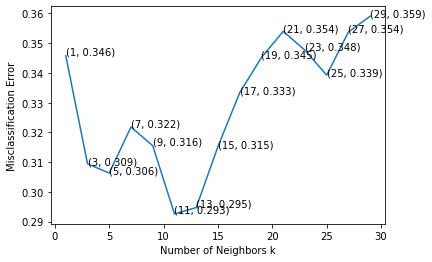

The misclassification error for each k value is : [0.346 0.309 0.306 0.322 0.316 0.293 0.295 0.315 0.333 0.345 0.354 0.348
 0.339 0.354 0.359]


In [648]:
# Creating odd list of K values
my_K_list = list(range(0, 30))
neighbors = list(filter(lambda x: x%2 != 0, my_K_list))

# empty list that will hold cv scores
cv_scores = []

# Perform K-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv=3, scoring='f1')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k =neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# Plotting misclassification error vs optimal_k
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE, 3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors k')
plt.ylabel('Misclassification Error')
plt.show()

print('The misclassification error for each k value is :', np.round(MSE, 3))

In [649]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model with
knn.fit(x_train, y_train)

# predict the response
pred = knn.predict(x_test)

pred

array([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,

In [650]:
knn_acc = round(knn.score(x_train,y_train)*100, 2)
print("Accuracy: ", knn_acc,'%')

82.56 %


In [657]:
kf = KFold(n_splits = 5, random_state=2)

# Print CV accuracy estimate:
scores = cross_val_score(knn, x_train, y_train, cv=kf, scoring='f1')

mean_acc_knn = scores.mean()*100

print('Scores: ', scores*100, '%')
print('Mean: ', mean_acc_log, '%')
print('Standard Deviation: ', scores.std()*100, '%\n')

pred = cross_val_score(knn, x_train, y_train, cv=kf)
print('Confusion Matrix: \n' ,confusion_matrix(y_train, pred),'\n')

print("Precision: ", round(precision_score(y_train, pred)*100, 2),'%')
print("Recall: ", round(recall_score(y_train, pred)*100, 2), '%')
print('F1 Score: ', round(f1_score(y_train, pred)*100, 2), '%')

Scores:  [62.71186441 78.20512821 75.38461538 65.54621849 76.92307692] %
Mean:  70.96168255899468 %
Standard Deviation:  6.3531810403590345 %



ValueError: Found input variables with inconsistent numbers of samples: [889, 5]

In [651]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

y_pred= knn.predict(x_test)
print(y_pred)

[0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0
 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 0 0
 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0
 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0
 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0
 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0
 1 1 1 1 1 0 0 1 0 0 0]


In [652]:
knn_acc = round(knn.score(x_train,y_train)*100, 2)
print(knn_acc,'%')

83.46 %


In [653]:
# print('Scores: ', scores*100, '%')
# print('Mean: ', mean_acc_knn, '%')
# print('Standard Deviation: ', scores.std()*100, '%\n')
kf = KFold(n_splits = 5, random_state = 2)
pred= cross_val_predict(knn_optimal, x_train, y_train, cv=kf)
print('Confusion Matrix: \n' ,confusion_matrix(y_train, pred), '\n')
knn_acc = round(knn_optimal.score(x_train,y_train)*100, 2)
print("Accuracy: ", knn_acc,'%')

print("Precision: ", round(precision_score(y_train, pred)*100, 2),'%')
print("Recall:  ", round(recall_score(y_train, pred)*100, 2), '%')
print('F1 Score: ', round(f1_score(y_train, pred)*100, 2), '%')

Confusion Matrix: 
 [[487  62]
 [115 225]] 

Accuracy:  82.56 %
Precision:  78.4 %
Recall:   66.18 %
F1 Score:  71.77 %


In [654]:

kf = KFold(n_splits = 10, random_state = 2)

pred= cross_val_predict(knn, x_train, y_train, cv=kf)
knn_acc = round(knn.score(x_train,y_train)*100, 2)
print(knn_acc,'%')
print('F1 Score: ', round(f1_score(y_train, pred)*100, 2), '%')
print('Confusion Matrix: \n' ,confusion_matrix(y_train, pred), '\n')

print("Precision: ", round(precision_score(y_train, pred)*100, 2),'%')
print("Recall:  ", round(recall_score(y_train, pred)*100, 2), '%')
print('F1 Score: ', round(f1_score(y_train, pred)*100, 2), '%')

83.46 %
F1 Score:  73.51 %
Confusion Matrix: 
 [[476  73]
 [100 240]] 

Precision:  76.68 %
Recall:   70.59 %
F1 Score:  73.51 %


In [655]:
# Print CV accuracy estimate:
#print(cross_val_score(KNeighborsClassifier(), X_test, y_test, cv = kf).mean())

scores= cross_val_score(KNeighborsClassifier(), x_train, y_train, cv = kf, scoring='accuracy')

mean_acc_knn = scores.mean()*100

print('Scores: ', scores*100, '%')
print('Mean: ', mean_acc_knn, '%')
print('Standard Deviation: ', scores.std()*100, '%\n')

pred= cross_val_predict(knn, X_train, y_train, cv=kf)
print('Confusion Matrix: \n' ,confusion_matrix(y_train, pred), '\n')

print("Precision: ", round(precision_score(y_train, pred)*100, 2),'%')
print("Recall: ", round(recall_score(y_train, pred)*100, 2), '%')
print('F1 Score: ', round(f1_score(y_train, pred)*100, 2), '%')

Scores:  [71.91011236 84.26966292 76.40449438 84.26966292 83.14606742 82.02247191
 82.02247191 74.15730337 85.39325843 81.81818182] %
Mean:  80.54136874361595 %
Standard Deviation:  4.432965546515949 %

Confusion Matrix: 
 [[481  68]
 [116 224]] 

Precision:  76.71 %
Recall:  65.88 %
F1 Score:  70.89 %
